# Cycle GAN

In [1]:
import pandas as pd
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset
### Load data from csv

In [2]:
# load all csv files in a folder and return a single dataframe
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports/constant_speed_interventions/"

def load_csv(path):
    all_files = glob.glob(path + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, sep=";")
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

df = load_csv(path)
print(df.shape)

(8120300, 39)


In [3]:
# drop columns that are not needed (all except 'LVP', 'AoP', 'AoQ', 'intervention', 'LVtot_kalibriert', 'LVtot', 'amimal')
df = df.drop(columns=['Time', 'RVtot_kalibriert', 'RVP', 'PaP', 'PaQ',
                        'VADspeed', 'VadQ', 'VADcurrent', 'Looperkennung', 'Phasenzuordnung', 'Extrasystolen',
                        'Ansaugphase', 'ECGcond', 'ECG', 'RVtot', 'LVV1', 'LVV2', 'LVV3', 'LVV4', 'LVV5',
                        'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect',
                        'contractility', 'preload', 'afterload', 'controller'])

# drop rows that contain NaN values
df = df.dropna()

print(df.shape) # (8120300, 39)
#print(df.head())

# select only rows where 'intervention' is 1
df = df[df['intervention'] == 1]   

print(df.shape) 

(8120300, 7)
(2159400, 7)


In [4]:
 # split data into training and test set
#df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False, stratify = None)

In [5]:
# hom many different animal ids are there?
print('Different animal IDs',df['animal'].unique())

# hom many different intervention ids are there?
print('Different interventions',df['intervention'].unique())

# length of data per animal
print(df.groupby('animal').size())

# randomly pick one animal as test data
test_animal = df['animal'].sample(n=1, random_state=1).iloc[0]
print('Test animal:', test_animal)
# test data
df_test = df[df['animal'] == test_animal]

# train data
train = df[df['animal'] != test_animal]
print('Train data shape:', train.shape)
print('Test data shape:', df_test.shape)
#print('The test data is {} percent of the whole data'.format(100/train.shape[0]*test.shape[0]))

df_train = train
print('Unique animals in df_train: ',train['animal'].unique())
print('Unique animals in df_test: ',df_test['animal'].unique())

Different animal IDs [19 16 13 20 17 11]
Different interventions [1]
animal
11    451600
13    384800
16    444200
17    261100
19    282500
20    335200
dtype: int64
Test animal: 19
Train data shape: (1876900, 7)
Test data shape: (282500, 7)
Unique animals in df_train:  [16 13 20 17 11]
Unique animals in df_test:  [19]


### Subsample the date by a factor of 0.1 to remove noise from the data

In [6]:
df_train = df_train.to_numpy()
df_test = df_test.to_numpy()

def groupedAvg(myArray, N=2):
    result = np.cumsum(myArray, 0)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

print(df_train.shape, df_test.shape)
df_train = groupedAvg(df_train, N=10)
df_test = groupedAvg(df_test, N=10)
print(df_train.shape, df_test.shape)

df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

# add column names to df_train and df_test
df_train.columns = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'LVtot', 'animal', 'intervention']
df_test.columns = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'LVtot', 'animal', 'intervention']
# colums animal and intervention should be integers
df_train['animal'] = df_train['animal'].astype(int)
df_train['intervention'] = df_train['intervention'].astype(int)
df_test['animal'] = df_test['animal'].astype(int)
df_test['intervention'] = df_test['intervention'].astype(int)
#print(df_train.head(), df_test.head())


(1876900, 7) (282500, 7)
(187690, 7) (28250, 7)


In [7]:
# remove rows so that modulo 128 = 0
#df_train = df_train.iloc[:-(len(df_train) % 256), :]
#df_test = df_test.iloc[: - (df_test.shape[0] % 256)] # is laready a multiple of 128 for animal 17

#print(df_train.shape, df_test.shape)

### Dataset loader

In [8]:
# Train Dataset includes data from multiple animals

class TrainDataset(Dataset):
    def __init__(self, signal_A, signal_B, df):
        self.df = df
        self.signal_A = self.df[signal_A]
        self.signal_B = self.df[signal_B]

        # only data from a single animal per batch 
        for animal in self.df['animal'].unique():
            df_single_animal = self.df[self.df['animal'] == animal]
            
            # length should be modulo 256 = 0
            df_single_animal = df_single_animal.iloc[:-(len(df_single_animal) % 256), :]
            # creating tensor from df 
            tensor_A = torch.tensor(df_single_animal[signal_A].values)
            tensor_B = torch.tensor(df_single_animal[signal_B].values)

            # split tensor into tensors of size 256
            tensor_A = tensor_A.split(256)  # tensor shape (256, 1) 
            tensor_B = tensor_B.split(256)       

            # stack tensors
            stack_A = torch.stack(tensor_A).unsqueeze(1) 
            stack_B = torch.stack(tensor_B).unsqueeze(1) 
            #print(stack_A.shape, stack_B.shape)
            
            if animal == self.df['animal'].unique()[0]:
                # add stack
                self.tensor_A = stack_A
                self.tensor_B = stack_B
                
            else:
                # add stack
                self.tensor_A = torch.cat((self.tensor_A, stack_A), 0)
                self.tensor_B = torch.cat((self.tensor_B, stack_B), 0)
          

    def __len__(self):
        # signal_A and signal_B should have the same length
        return len(self.tensor_A)

    def __getitem__(self, index):
        # return the signal at the given index  # add data augmentation?
        return self.tensor_A[index], self.tensor_B[index]

In [9]:
# Test Dataset includes data from a single animal

class TestDataset(Dataset):
    def __init__(self, signal_A, signal_B, df):
        self.df = df
        self.signal_A = self.df[signal_A]
        self.signal_B = self.df[signal_B]

        # length should be modulo 256 = 0
        self.df = self.df.iloc[:-(len(self.df) % 256), :]
        
        # creating tensor from df 
        tensor_A = torch.tensor(self.df[signal_A].values)
        tensor_B = torch.tensor(self.df[signal_B].values)

        # split tensor into tensors of size 256
        tensor_A = tensor_A.split(256)  # tensor shape (256, 1) 
        tensor_B = tensor_B.split(256)       

        # stack tensors
        self.tensor_A = torch.stack(tensor_A).unsqueeze(1) 
        self.tensor_B = torch.stack(tensor_B).unsqueeze(1) 
        # print(self.tensor_A.shape, self.tensor_A.shape)


    def __len__(self):
        # signal_A and signal_B should have the same length
        return len(self.tensor_A)

    def __getitem__(self, index):
        # return the signal at the given index  # add data augmentation?
        return self.tensor_A[index], self.tensor_B[index]

In [10]:
SIG_A = "LVtot_kalibriert" #'sin' 
SIG_B = "LVtot" #'cos'

# create datasets with class SignalDataset
train_dataset = TrainDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_train)
test_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=10, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True,)

# length of train and test dataset
print(len(train_dataset), len(test_dataset))

730 110


### Generator

In [11]:
def double_conv_pad(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        # nn.InstanceNorm1d(out_channels),  # InstanceNorm1d is not working
        # nn.BatchNorm1d(out_channels),  # BatchNorm1d is not working
        nn.LeakyReLU(inplace=True),
        #nn.BatchNorm1d(out_channels),
        nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        #nn.InstanceNorm1d(out_channels), # InstanceNorm1d is not working
        # nn.BatchNorm1d(out_channels),  # BatchNorm1d is not working
        nn.LeakyReLU(inplace=True)
        #nn.BatchNorm1d(out_channels)
    ) 

class UnetGenerator(nn.Module):
    def __init__(self):
        super(UnetGenerator, self).__init__()
        self.maxpool = nn.MaxPool1d(2)

        self.down_conv1 = double_conv_pad(1, 32) 
        self.down_conv2 = double_conv_pad(32, 64) 
        self.down_conv3 = double_conv_pad(64, 128)
        self.down_conv4 = double_conv_pad(128, 256)

        self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.up_conv1 = double_conv_pad(256, 128)
        self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.up_conv2 = double_conv_pad(128, 64)
        self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.up_conv3 = double_conv_pad(64, 32)

        self.out = nn.Conv1d(32, 1, kernel_size=1)

    def forward(self, input):
        
        # batch_size, channels, tensor_size
        # encoder input -> 1, 1, 572
        #print(input.size())
        x1 = self.down_conv1(input)  # 
        #print(x1.size())  
        x2 = self.maxpool(x1) 
        #print(x2.size())
        x3 = self.down_conv2(x2)  #
        #print(x3.size())
        x4 = self.maxpool(x3) 
        #print(x4.size()) 
        x5 = self.down_conv3(x4)  #
        #print(x5.size()) 
        x6 = self.maxpool(x5)
        #print(x6.size())  
        x7 = self.down_conv4(x6)
        #print(x7.size())

        # decoder
        x = self.up_trans1(x7)
        x = self.up_conv1(torch.cat([x, x5], 1))
        x = self.up_trans2(x)
        x = self.up_conv2(torch.cat([x, x3], 1))
        x = self.up_trans3(x)
        x = self.up_conv3(torch.cat([x, x1], 1))
        x = self.out(x)
        #print(x.size())
        return x
    
x = torch.rand(1,1,256)
model = UnetGenerator()
#print(model(x))  # The model outputs a tensor of size 1, 1, 256, perfect
print(model(x).shape)

torch.Size([1, 1, 256])


### Discriminator

In [12]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.InstanceNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.block(x)
    
#x = torch.randn((1, 1, 128))
#block = Block(1, 32, 2)
#print(block(x).shape)

class AP_Discriminator(nn.Module):
    def __init__(self, in_channels=1, out_channels=[32,64,128,256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(in_channels, out_channels[0], kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        layers = []
        in_channels = out_channels[0]
        for out_channel in out_channels[1:]:
            layers.append(Block(in_channels, out_channel, stride=1 if out_channel == 256 else 2))
            in_channels = out_channel

        layers.append(nn.Conv1d(out_channels[-1], 1, kernel_size=3, stride=1, padding=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))
    
x = torch.randn((1, 1, 256))
disc = AP_Discriminator()
print(disc(x).shape)

torch.Size([1, 1, 32])


### Train model

In [23]:
# config

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2048  #1024 didsn't work so well
LEARNING_RATE = 1e-4  # 1e-5 was too small for 'LVtot_kalibriert' and 'LVtot'
LAMBDA_IDENTITY = 0.1
LAMBDA_CYCLE = 10.0
NUM_WORKERS = 4
NUM_EPOCHS = 3000
GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample
LOAD_MODEL = False
SAVE_MODEL = False
SIG_A = 'AoQ' # "LVtot_kalibriert"  
SIG_B = 'LVP' # "LVtot" 
CHECKPOINT_GEN_A2B = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_B)
CHECKPOINT_GEN_B2A = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_A =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_B =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_B)


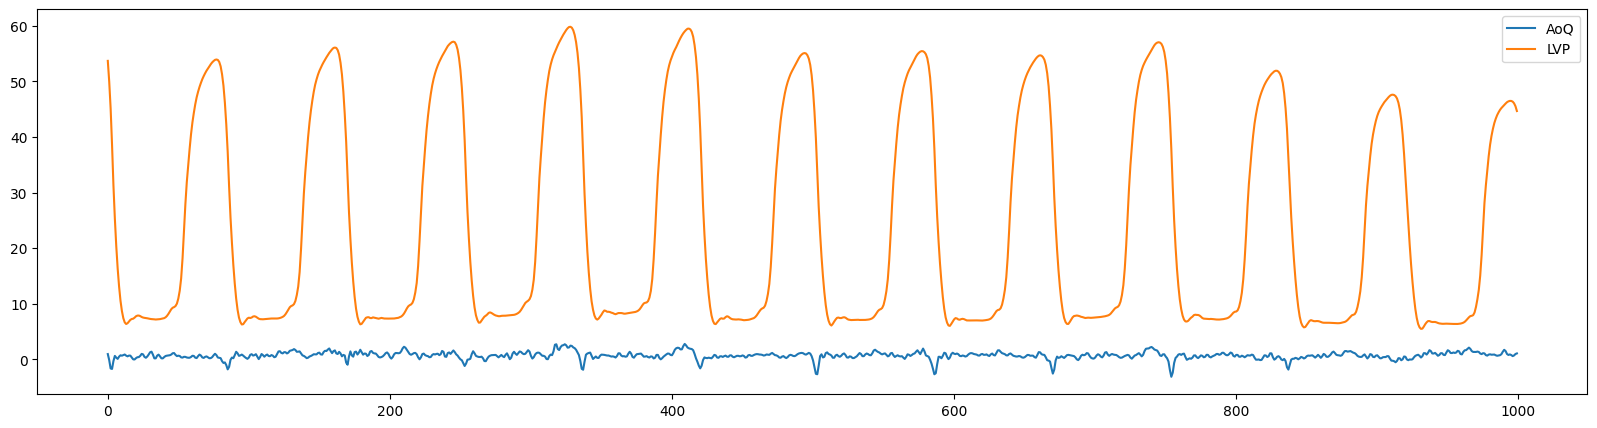

In [27]:
# Visualize the data we want to generate
plt.figure(figsize=(20, 5))
plt.plot(df_train[SIG_A][:1000], label='AoQ')
plt.plot(df_train[SIG_B][:1000], label='LVP')
plt.legend()
plt.show()

Generate fake signals
MSE G_A2B: 1007.0746, MSE G_B2A: 962.7594
MSE G_A2B: 1006.4923, MSE G_B2A: 946.3735
MSE G_A2B: 1182.0110, MSE G_B2A: 1127.9310
MSE G_A2B: 1405.1265, MSE G_B2A: 1367.7772
MSE G_A2B: 1569.8005, MSE G_B2A: 1525.1997
MSE G_A2B: 1411.1367, MSE G_B2A: 1373.3765
MSE G_A2B: 1183.6316, MSE G_B2A: 1142.3010
MSE G_A2B: 1067.8199, MSE G_B2A: 1024.6575
MSE G_A2B: 1239.0758, MSE G_B2A: 1190.5087
MSE G_A2B: 1467.7478, MSE G_B2A: 1443.9606
MSE G_A2B: 1017.6879, MSE G_B2A: 986.1786
MSE G_A2B: 937.1085, MSE G_B2A: 904.6274
MSE G_A2B: 1175.7864, MSE G_B2A: 1100.4111
MSE G_A2B: 1333.4124, MSE G_B2A: 1283.5908
MSE G_A2B: 1453.4806, MSE G_B2A: 1396.9836
MSE G_A2B: 1242.8193, MSE G_B2A: 1190.8779
MSE G_A2B: 1284.0956, MSE G_B2A: 1220.2566
MSE G_A2B: 1344.5618, MSE G_B2A: 1306.0551
MSE G_A2B: 1195.6775, MSE G_B2A: 1145.0493
MSE G_A2B: 1081.6681, MSE G_B2A: 1062.2002
MSE G_A2B: 1095.2919, MSE G_B2A: 1057.6541
MSE G_A2B: 1074.9106, MSE G_B2A: 1051.6829
MSE G_A2B: 1138.0918, MSE G_B2A: 1060

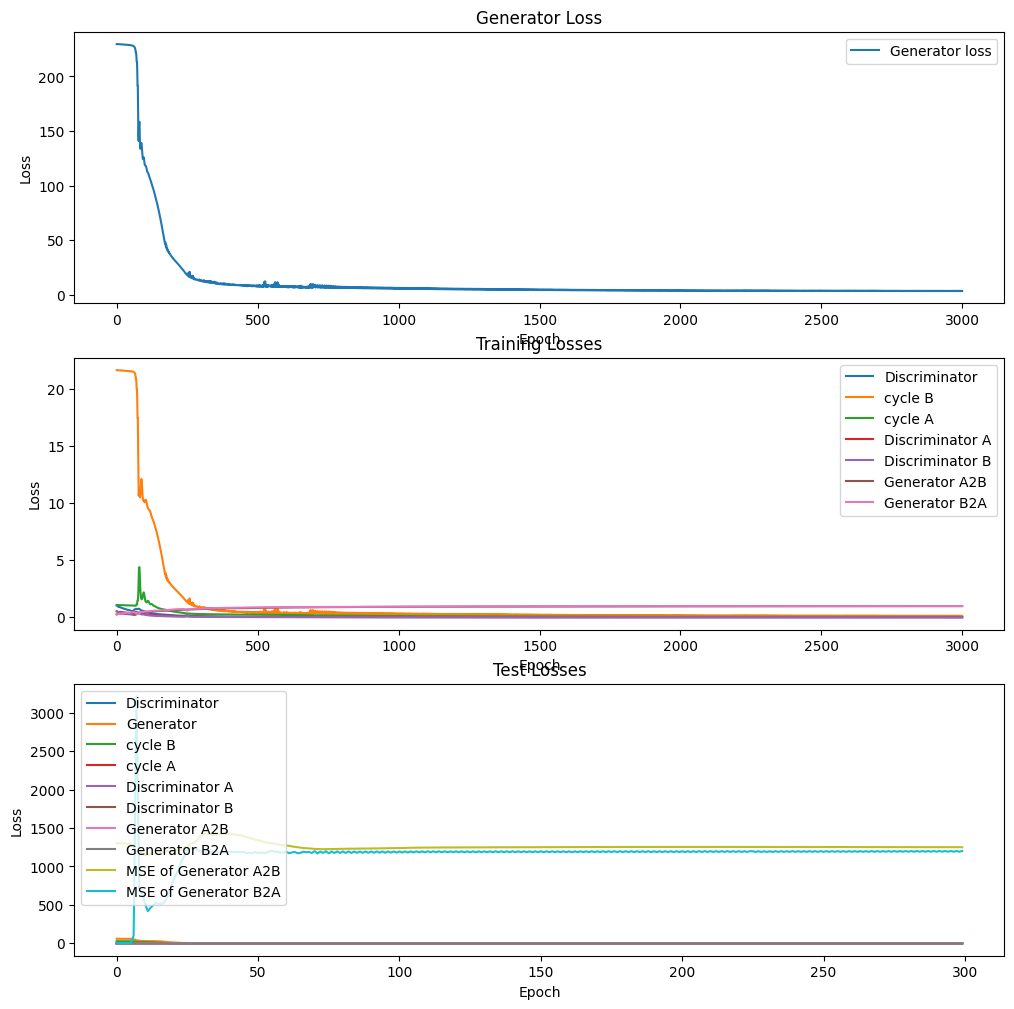

In [24]:
# initialize generator and discriminator
gen_A = UnetGenerator().to(DEVICE)
gen_B = UnetGenerator().to(DEVICE)
disc_A = AP_Discriminator().to(DEVICE)
disc_B = AP_Discriminator().to(DEVICE)

# optimizers for discriminator and generator 
opt_disc = torch.optim.AdamW(                                           # Adam statt AdamW 
    list(disc_A.parameters()) + list(disc_B.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_A.parameters()) + list(gen_B.parameters()),
    lr=LEARNING_RATE,
)

l1 = nn.L1Loss() # L1 loss for cycle consistency and identity loss
mse = nn.MSELoss() # MSE loss for adversarial loss

# create datasets with class SignalDataset
dataset = TrainDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_train)
test_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)
gen_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)

# Data loader
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)
gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=True, pin_memory=True,)

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

train_losses = {
            'cycle_B_loss': [],
            'cycle_A_loss': [],
            'identity_A_loss': [],
            'identity_B_loss': [],
            'disc_A_loss': [],
            'disc_B_loss': [],
            'gen_A2B_loss': [],
            'gen_B2A_loss': [],
            'd_loss': [],
            'g_loss': [],
        }

test_losses = {
    'cycle_B_loss': [],
    'cycle_A_loss': [],
    'disc_A_loss': [],
    'disc_B_loss': [],
    'gen_A2B_loss': [],
    'gen_B2A_loss': [],
    'd_loss': [],
    'g_loss': [],
    'mse_G_A2B': [],
    'mse_G_B2A': [],
}

B_reals = 0
B_fakes = 0


# training loop

for epoch in range(NUM_EPOCHS):

    for sig_A, sig_B in loader:
        # convert to float16
        sig_A = sig_A.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        sig_B = sig_B.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        sig_A = sig_A.to(DEVICE)
        sig_B = sig_B.to(DEVICE)

        #  -------------------------------- #
        #  ----- train discriminators ----- #
        #  -------------------------------- #
        with torch.cuda.amp.autocast(): # necessary for float16

            fake_B = gen_B(sig_A) # generate fake signal B
            d_B_real = disc_B(sig_B) # output of discriminator B for real signal B
            d_B_fake = disc_B(fake_B.detach()) # output of discriminator B for fake signal B (detached from generator)

            B_reals += d_B_real.mean().item()
            B_fakes += d_B_fake.mean().item()

            # Loss between dicriminator (with real signal) output and 1 - The discriminator should output 1 for real signals
            d_B_real_loss = mse(d_B_real, torch.ones_like(d_B_real))  
            # Loss between dicriminator (with fake signal) output and 0 - The discriminator should output 0 for fake signals
            d_B_fake_loss = mse(d_B_fake, torch.zeros_like(d_B_fake)) 
            # Total loss for discriminator B
            d_B_loss = d_B_real_loss + d_B_fake_loss

            fake_A = gen_A(sig_B)
            d_A_real = disc_A(sig_A)
            d_A_fake = disc_A(fake_A.detach()) 
            d_A_real_loss = mse(d_A_real, torch.ones_like(d_A_real)) 
            d_A_fake_loss = mse(d_A_fake, torch.zeros_like(d_A_fake))  
            d_A_loss = d_A_real_loss + d_A_fake_loss

            # Total loss for discriminator A
            d_loss = d_A_loss + d_B_loss  # in cycle GAN paper they halve the loss

        # exit amp.auto_cast() context manager and backpropagate 
        opt_disc.zero_grad() 
        d_scaler.scale(d_loss).backward()  
        d_scaler.step(opt_disc)  
        d_scaler.update()
        

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 
        with torch.cuda.amp.autocast():

            # ----- adversarial loss for both generators ----- #
            d_A_fake = disc_A(fake_A) # disc_A should output 0 for fake signal A
            d_B_fake = disc_B(fake_B) # disc_B should output 0 for fake signal B
            # loss between discriminator output and 0 - The discriminator should output 0 for fake signals
            g_A_loss = mse(d_A_fake, torch.ones_like(d_A_fake)) # was ones_like before  
            g_B_loss = mse(d_B_fake, torch.ones_like(d_B_fake)) # was ones_like before

            # ----- cycle consistency loss ----- #
            cycle_B = gen_B(fake_A) # fake_A = gen_B2A(sig_B)  
            cycle_A = gen_A(fake_B) # fake_B = gen_A2B(sig_A)
            cycle_B_loss = l1(sig_B, cycle_B)  # l1 loss: Mean absolute error between each element in the input x and target y.
            cycle_A_loss = l1(sig_A, cycle_A)

            # ----- identity loss ----- #
            id_B = gen_B(sig_B) 
            id_A = gen_A(sig_A)
            id_B_loss = l1(sig_B, id_B)
            id_A_loss = l1(sig_A, id_A)

            # put it all together
            g_loss = (
                g_A_loss +
                g_B_loss +
                cycle_B_loss * LAMBDA_CYCLE +
                cycle_A_loss * LAMBDA_CYCLE +
                id_B_loss * LAMBDA_IDENTITY +  # LAMBDA_IDENTITY = 0.0 -> no identity loss 
                id_A_loss * LAMBDA_IDENTITY    # we could remove it to increase training speed
            )

        # update gradients of generator
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward() 
        g_scaler.step(opt_gen) 
        g_scaler.update()

    # save losses
    train_losses['d_loss'].append(d_loss.item())
    train_losses['g_loss'].append(g_loss.item())
    train_losses['cycle_B_loss'].append(cycle_B_loss.item())
    train_losses['cycle_A_loss'].append(cycle_A_loss.item())
    #train_losses['identity_A_loss'].append(id_A_loss.item())
    #train_losses['identity_B_loss'].append(id_B_loss.item())
    train_losses['disc_A_loss'].append(d_A_loss.item())
    train_losses['disc_B_loss'].append(d_B_loss.item())
    train_losses['gen_A2B_loss'].append(g_A_loss.item())
    train_losses['gen_B2A_loss'].append(g_B_loss.item())

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    #  validation every 10 epochs
    if (epoch+1) % 10 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_A.eval()  # set discriminator to evaluation mode
            disc_B.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_B.eval()
            gen_A.eval()

            # store losses for testing
            test_mse_G_A2B = 0
            test_mse_G_B2A = 0
            test_g_A_loss = 0
            test_g_B_loss = 0
            test_cycle_B_loss = 0
            test_cycle_A_loss = 0
            test_d_A_loss = 0
            test_d_B_loss = 0
            test_g_loss = 0
            test_d_loss = 0

            for sig_A, sig_B in test_loader:
                # convert to float16
                sig_A = sig_A.float()
                sig_B = sig_B.float()

                # move to GPU
                sig_A = sig_A.to(DEVICE)
                sig_B = sig_B.to(DEVICE)

                fake_B = gen_B(sig_A)
                fake_A = gen_A(sig_B)
        
                # calculate mse loss of fake signals and real signals
                test_mse_G_A2B = mse(sig_B, fake_B)
                test_mse_G_B2A = mse(sig_A, fake_A)

                # calculate Generator loss
                test_g_A_loss = mse(disc_B(fake_B), torch.zeros_like(disc_B(fake_B))) #was ones_like before
                test_g_B_loss = mse(disc_A(fake_A), torch.zeros_like(disc_A(fake_A)))

                # ----- cycle loss ----- #
                cycle_B = gen_B(fake_A)  # fake_A = gen_B2A(sig_B)
                cycle_A = gen_A(fake_B)  # fake_B = gen_A2B(sig_A)
                test_cycle_B_loss = l1(sig_B, cycle_B)
                test_cycle_A_loss = l1(sig_A, cycle_A)

                # ----- identity loss ----- #
                # I am not tracking the identity loss because it is 0
                id_B = gen_B(sig_B)
                id_A = gen_A(sig_A)
                id_B_loss = l1(sig_B, id_B)
                id_A_loss = l1(sig_A, id_A)

                # ----- discriminator loss ----- #
                test_d_A_loss = mse(disc_A(sig_A), torch.ones_like(disc_A(sig_A))) + mse(disc_A(fake_A), torch.zeros_like(disc_A(fake_A)))
                test_d_B_loss = mse(disc_B(sig_B), torch.ones_like(disc_B(sig_B))) + mse(disc_B(fake_B), torch.zeros_like(disc_B(fake_B)))
                
                # ----- generator loss ----- #
                test_g_loss = test_g_A_loss + test_g_B_loss + test_cycle_B_loss + test_cycle_A_loss + id_B_loss + id_A_loss
                test_d_loss = (test_d_A_loss + test_d_B_loss) / 2

                # save losses
                test_losses['d_loss'].append(test_d_loss.item())
                test_losses['g_loss'].append(test_g_loss.item())
                test_losses['cycle_B_loss'].append(test_cycle_B_loss.item())
                test_losses['cycle_A_loss'].append(test_cycle_A_loss.item())
                test_losses['disc_A_loss'].append(test_d_A_loss.item())
                test_losses['disc_B_loss'].append(test_d_B_loss.item())
                test_losses['gen_A2B_loss'].append(test_g_A_loss.item())
                test_losses['gen_B2A_loss'].append(test_g_B_loss.item())
                test_losses['mse_G_A2B'].append(test_mse_G_A2B.item()/len(test_loader))
                test_losses['mse_G_B2A'].append(test_mse_G_B2A.item()/len(test_loader))

            #  ------------------------------------- #   
            #  ------- Generate fake signals ------- #
            #  ------------------------------------- #
            
            # generate fake signals every 100 epochs
            # Generation is in the validation loop because this was easier to implement
            
            if (epoch+1) % GENERATION_AFTER_EPOCH == 0:
                print('Generate fake signals')
                utils.save_predictions(gen_loader, gen_B, gen_A, fake_A, fake_B, DEVICE, mse)
                print('Check')

        # activate training mode again
        disc_A.train()  
        disc_B.train()
        gen_B.train()
        gen_A.train()

# ----------------------------------- #
# -------------- PLOT --------------- #
# ----------------------------------- #

# plot losses for each epoch in subplots
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(train_losses['g_loss'], label='Generator loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Generator Loss')
ax[0].legend()
ax[1].plot(train_losses['d_loss'], label='Discriminator')
ax[1].plot(train_losses['cycle_B_loss'], label='cycle B')
ax[1].plot(train_losses['cycle_A_loss'], label='cycle A')
ax[1].plot(train_losses['disc_A_loss'], label='Discriminator A')
ax[1].plot(train_losses['disc_B_loss'], label='Discriminator B')
ax[1].plot(train_losses['gen_A2B_loss'], label='Generator A2B')
ax[1].plot(train_losses['gen_B2A_loss'], label='Generator B2A')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training Losses')
ax[1].legend()
ax[2].plot(test_losses['d_loss'], label='Discriminator')
ax[2].plot(test_losses['g_loss'], label='Generator')
ax[2].plot(test_losses['cycle_B_loss'], label='cycle B')
ax[2].plot(test_losses['cycle_A_loss'], label='cycle A')
ax[2].plot(test_losses['disc_A_loss'], label='Discriminator A')
ax[2].plot(test_losses['disc_B_loss'], label='Discriminator B')
ax[2].plot(test_losses['gen_A2B_loss'], label='Generator A2B')
ax[2].plot(test_losses['gen_B2A_loss'], label='Generator B2A')
ax[2].plot(test_losses['mse_G_A2B'], label='MSE of Generator A2B')
ax[2].plot(test_losses['mse_G_B2A'], label='MSE of Generator B2A')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Test Losses')
ax[2].legend()

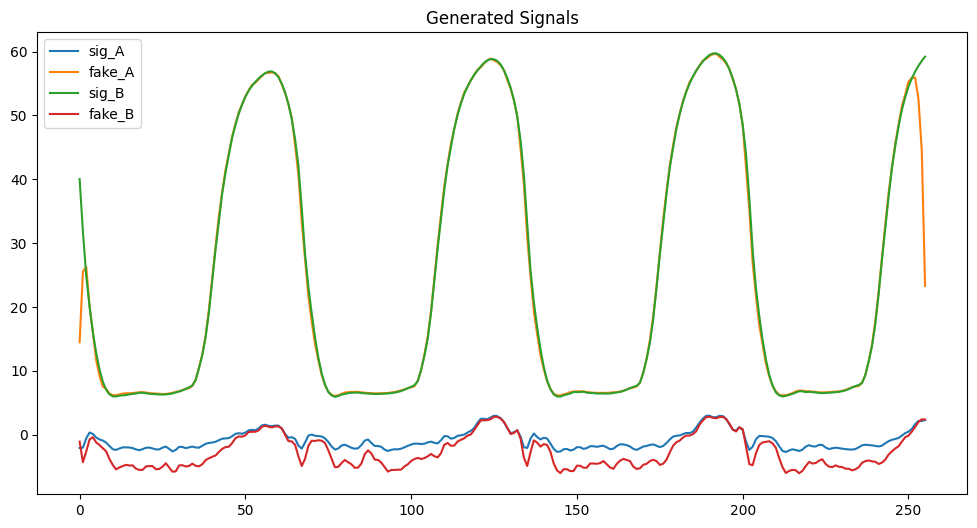

In [25]:
# load csv
df = pd.read_csv('generated_signals.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# plot df
df.plot(figsize=(12, 6), title='Generated Signals')

# save plot
plt.savefig('{}_to_{}.png'.format(SIG_A, SIG_B), bbox_inches='tight')

<Figure size 640x480 with 0 Axes>